## Autoencoder with GMM on MNIST
Created by: Daniel L. Marino (marinodl@vcu.edu)

In [1]:
import tensorflow as tf
import numpy as np

from twodlearn.feedforward import *
from twodlearn.GMM import *
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline


opt = { 'tol'                : 0.000000001,
        'n_hidden_enc'       : [500, 80, 100],
        'n_outputs_enc'      : 2,
        'n_hidden_dec'       : [100, 80, 500],
        'n_kernels'          : 15,
        'max_steps'          : 15000,
        'batch_size'         : 1000,
        'weight_loss'        : 0.00005,
        'auto_learning_rate' : 0.01,
        'gmm_learning_rate'  : 0.001,
        'n_hidden_class'     : [100, 100],
        'classifier_weight'  : 0.0 #0.1
      }

### 1. Load MNIST

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

batch_X, batch_y = mnist.train.next_batch(100)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Load MNIST
the network is conformed by encoder (enc_net) and a decoder(dec_net). The decoder works also as a generative model (gen_conf)

Best configurations:

* n_hidden_enc = [100, 50, 15] <br>
  n_outputs_enc = 10 <br>
  n_hidden_dec = [15, 50, 100] <br>
  n_kernels = 20 <br>
 

In [3]:
sess = tf.InteractiveSession()

n_inputs_enc = 28*28
#n_hidden = [200, 100, 50, 25, 3, 100, 200] # [100, 50, 15, 3, 15, 50, 100] # [150, 100, 50, 15, 3, 50, 100] 
n_hidden_enc = opt['n_hidden_enc']  # [100, 50, 15, 3, 15, 50, 100] # [150, 100, 50, 15, 3, 50, 100] 
n_outputs_enc = opt['n_outputs_enc']

n_inputs_dec = n_outputs_enc
n_hidden_dec = opt['n_hidden_dec']
n_outputs_dec = 28*28

afunction = tf.nn.softplus
# Define the autoencoder
enc_net= MlpNet( n_inputs_enc, n_outputs_enc, n_hidden_enc, afunction= afunction ,name='autoencoder')
enc_conf = enc_net.setup() #auto_net.setup(opt['batch_size'])

dec_net= MlpNet( n_inputs_dec, n_outputs_dec, n_hidden_dec, afunction= afunction ,name='autoencoder')
dec_conf = dec_net.setup(inputs = enc_conf.y) #auto_net.setup(opt['batch_size'])
gen_conf = dec_net.setup()

# Define the loss
r_x = tf.sigmoid(dec_conf.y) # reconstructed input

weight_loss = tf.sqrt(tf.nn.l2_loss(enc_net.out_layer.weights))
for i in range(len(n_hidden_enc)):
    weight_loss += tf.sqrt(tf.nn.l2_loss(enc_net.full_layers[i].weights))

weight_loss += tf.sqrt(tf.nn.l2_loss(dec_net.out_layer.weights))
for i in range(len(n_hidden_dec)):
    weight_loss += tf.sqrt(tf.nn.l2_loss(dec_net.full_layers[i].weights))

    
loss = tf.reduce_mean( tf.pow(r_x - enc_conf.inputs, 2) ) + opt['weight_loss']*weight_loss


#loss = (-tf.reduce_mean( tf.reduce_mean(enc_conf.inputs * tf.log(r_x + opt['tol']) + 
#                                      (1-enc_conf.inputs) * tf.log(1 - r_x + opt['tol']) )  ) + 
#                       opt['weight_loss']*weight_loss)



#auto_optimizer = optimizer = tf.train.AdamOptimizer(opt['auto_learning_rate']).minimize(loss)
#auto_optimizer = optimizer = tf.train.MomentumOptimizer(0.05, 0.5).minimize(loss)

In [4]:
'''
classifier = AffineLayer(n_outputs_enc, 10)
classifier_y = classifier.evaluate(enc_conf.y)
classifier_reg = opt['weight_loss']*tf.sqrt(tf.nn.l2_loss(classifier.weights))
'''

train_labels = tf.placeholder(tf.float32)
if opt['classifier_weight'] > 0.001:
    classifier = MlpNet( n_outputs_enc, 10, opt['n_hidden_class'], 
                         afunction= afunction, name='classifier')
    classifier_conf = classifier.setup(inputs = enc_conf.y)
    classifier_y = classifier_conf.y
    classifier_reg = opt['weight_loss']*( 
                            tf.sqrt(tf.nn.l2_loss(classifier.out_layer.weights)) + 
                            tf.sqrt(tf.nn.l2_loss(classifier.full_layers[0].weights)) )



    loss = opt['classifier_weight']*tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            labels= train_labels, logits= classifier_y)) + \
        classifier_reg + \
        loss

auto_optimizer = optimizer = tf.train.AdamOptimizer(opt['auto_learning_rate']).minimize(loss)

## GMM model

In [5]:
n_kernels = opt['n_kernels']
n_dim = n_outputs_enc

gmm_x = tf.placeholder( tf.float32)

gmm_w= tf.Variable(tf.truncated_normal( [1, n_kernels + 2*n_kernels*n_dim ], stddev=1.0),
                   name= 'gmm_weights'
                  )
gmm_params = GmmParamsLayer(n_dim, n_kernels, diagonal= True)
gmm_model = GmmModel(n_dim, n_kernels, diagonal= True)

# transform parameters to 'valid' parameters
mu_r, sigma_r, w_r = gmm_params.evaluate(gmm_w)

# evaluate the gaussian mixture model using the 'valid' parameters
gmm_out = gmm_model.evaluate(gmm_x, mu_r, sigma_r, w_r)

# compute the loss of the gmm
gmm_loss = tf.reduce_sum(-tf.log(gmm_out + 0.000001))

# Optimizer.
optimizer = tf.train.AdamOptimizer(opt['gmm_learning_rate']).minimize(gmm_loss) #0.001

### 3. Training of autoencoder

In [6]:
n_logging = 1000

tf.initialize_all_variables().run()
print('Initialized')

mean_loss = 0.0
for step in range(0, opt['max_steps']):
    batch_x, batch_y= mnist.train.next_batch(opt['batch_size'])
    
    
    # run gradient descent to train the discriminator
    feed_dict = {enc_conf.inputs : batch_x, train_labels : batch_y}
    
    #print('training')
    _, l = sess.run([auto_optimizer, loss],feed_dict=feed_dict)
    mean_loss += l
    
    if step%n_logging == 0:
        # evaluate testing error
        batch_x, batch_y= mnist.test.next_batch(opt['batch_size'])
        test_loss = sess.run([loss],{enc_conf.inputs : batch_x, train_labels : batch_y})
        
        print( step, ' | mean_loss:', mean_loss/n_logging, ' | test_loss:', test_loss)
        
        
        
        weights = sess.run([enc_net.full_layers[i].weights for i in range(len(n_hidden_enc))] + 
                           [enc_net.out_layer.weights] +
                           [dec_net.full_layers[i].weights for i in range(len(n_hidden_dec))] +
                           [dec_net.out_layer.weights]
                          )
        
        print( [ np.sqrt(np.sum(w**2)) for w in weights] )
        #print( np.sqrt(np.max( np.linalg.eigvals( np.matmul( np.transpose(weights[0]), weights[0]  )))))
        #print( np.sqrt(np.max( np.linalg.eigvals( np.matmul( np.transpose(weights[1]), weights[1]  )))))
        
        print( [np.sqrt(np.max( np.linalg.eigvals( np.matmul( np.transpose(w), w  )))) for w in weights] )
        
        #sing_vals = np.sort(np.linalg.eigvals( np.matmul( np.transpose(weights[0]), weights[0]  )))[::-1]
        #print( sing_vals[0:5] )
        
        mean_loss = 0.0

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
0  | mean_loss: 0.000254693925381  | test_loss: [0.10935039]
[4.1402459, 4.7906828, 4.9402418, 1.4247317, 4.8701062, 5.0923662, 5.3661551, 23.163498]
[0.40471208, 1.1799012, 1.0673448, 1.0656506, 3.504092, 1.1452384, 2.0072756, 6.1723189]
1000  | mean_loss: 0.0484251402915  | test_loss: [0.042274103]
[41.259338, 15.192429, 8.3395691, 2.0550554, 3.9066331, 8.1331291, 13.85068, 29.221645]
[16.510925, 7.5975342, 5.8810515, 1.6036608, 2.8561871, 5.9528952, 6.371037, 16.911541]
2000  | mean_loss: 0.0411461690664  | test_loss: [0.041389678]
[51.240707, 17.480463, 9.8468065, 2.7331705, 4.174685, 9.2663755, 13.767769, 25.82979]
[20.422235, 8.1770916, 6.8362336, 2.0544741, 2.9872375, 6.6730127, 6.1855173, 13.356578]
3000  | mean_loss: 0.04030125916  | test_loss: [0.040276002]
[50.332363, 17.79394, 10.213062, 3.196774, 4.379653, 9.5570765, 13.669769, 24.754614]
[18.880035, 8.1987095, 6.8039541, 2.349494, 3.1645

In [7]:
def img_rearange(images, M, N):
    H = images.shape[1]
    W = images.shape[2]
    n_images = images.shape[0]
    
    images = np.reshape(images, (N, H*M, W) )
    # reshape(images, H, W*N, M);
    images = np.reshape( np.transpose(images, (1, 0, 2) ),  (H*M, W*N));
    return images

In [8]:
%matplotlib inline

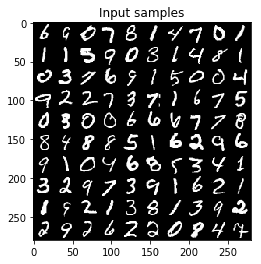

In [9]:
# plot real 
batch_x, batch_y= mnist.train.next_batch(100)
train_x = img_rearange(np.reshape(batch_x, [-1,28,28]), 10, 10)

fig = plt.figure(); ax = fig.gca()
plt.rcParams["figure.figsize"] = [12, 9]
ax.imshow(train_x, cmap='gray')
ax.set_title('Input samples')

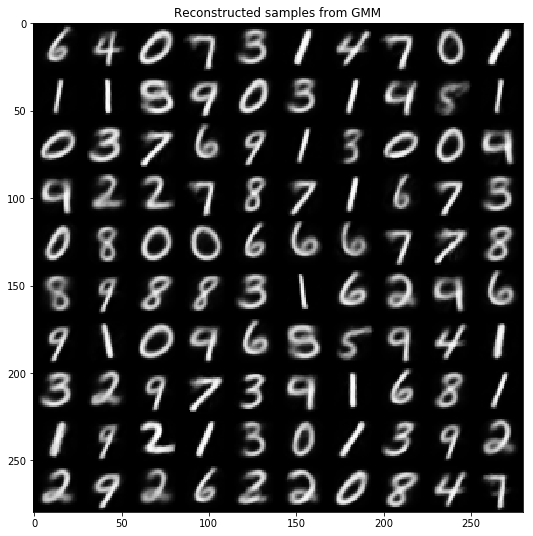

In [10]:
# print('training')
r_x_data = sess.run([r_x],feed_dict={enc_conf.inputs : batch_x})

fig = plt.figure(); ax = fig.gca()
plt.rcParams["figure.figsize"] = [12, 9]
ax.imshow(img_rearange(np.reshape(r_x_data, [-1,28,28]), 10, 10), cmap='gray')
ax.set_title( 'Reconstructed samples from GMM')

## gmm model

In [17]:
num_steps = 10000 #1000
n_logging = 1000
n_test_logg = 10

print('Initialized')

mean_loss= 0
train_accuracy= 0

batch_x, _= mnist.train.next_batch(opt['batch_size']*3)
batch_h = sess.run([enc_conf.y], feed_dict={enc_conf.inputs : batch_x})

h_mean = np.mean(batch_h[0], 0)
h_std  = np.std(batch_h[0], 0)

batch_h[0] = (batch_h[0] - h_mean)/h_std

for step in range(num_steps):
       
    _, l = sess.run([optimizer, gmm_loss],feed_dict={gmm_x : batch_h[0]})
    mean_loss += l    
    
    
    if step%n_logging == 0:                
        print(step, ' | loss:', mean_loss/n_logging)
        mean_loss= 0

Initialized
0  | loss: 9.05579003906
1000  | loss: 8117.53302148
2000  | loss: 7497.9057002
3000  | loss: 7336.52636523
4000  | loss: 7094.41379736
5000  | loss: 6964.38730127
6000  | loss: 6925.55131982
7000  | loss: 6920.2164043
8000  | loss: 6919.80102393
9000  | loss: 6919.71896436


In [18]:
def gmm_sampling(mu, sigma, w, n_samples=1):
    # generates random vectors, sampled from a gausian mixture model
    #  
    #     - mu: 3d tensor containing the means for the gaussians.
    #           the "depth" dimention (3rd) is used to index the
    #           gaussians.    [ kernel_id, dim]
    #     - sigma: 3d tensor containing the covariance matrix of the
    #              gaussians. [ kernel_id, dim] for diagonal matrices
    #     - w: vector in form of a 3d tensor containing the weights
    #          for each one of the gaussians, they have to sum one. 
    #          [kernel_id]
    n_kernels = mu.shape[0]
    n_dim = mu.shape[1]
    
    # random sample the kernel from which the output samples are going
    # to be drawn
    kernel_id= np.argmax(np.random.multinomial(1, w, size=[n_samples]), axis=1 )
    
    out = np.zeros([n_samples, n_dim])
    for i in range(n_samples):
        out[i,:]= np.random.multivariate_normal(mu[kernel_id[i],:], np.diag(sigma[kernel_id[i],:])) # if diagonal
    
    return out;

In [19]:
mu, sigma, w = sess.run([mu_r, sigma_r, w_r])

mu = np.squeeze(mu)
sigma = np.squeeze(sigma)
w = np.squeeze(w)


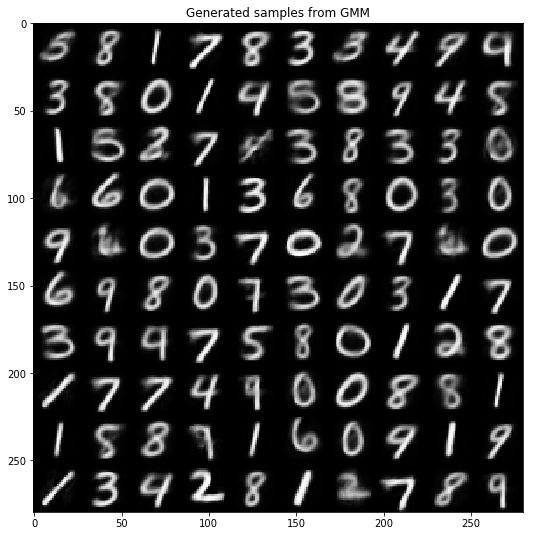

In [20]:
generated_h = gmm_sampling(mu, sigma, w, 100)
generated_h = (generated_h*h_std) + h_mean

generated_x = sess.run([tf.sigmoid(gen_conf.y)], feed_dict={gen_conf.inputs : generated_h})

# show the images
generated_img = img_rearange(np.reshape(generated_x[0], [-1,28,28]), 10, 10)

fig = plt.figure(); ax = fig.gca()
plt.rcParams["figure.figsize"] = [12, 9]
ax.imshow(generated_img, cmap='gray')
ax.set_title( 'Generated samples from GMM')

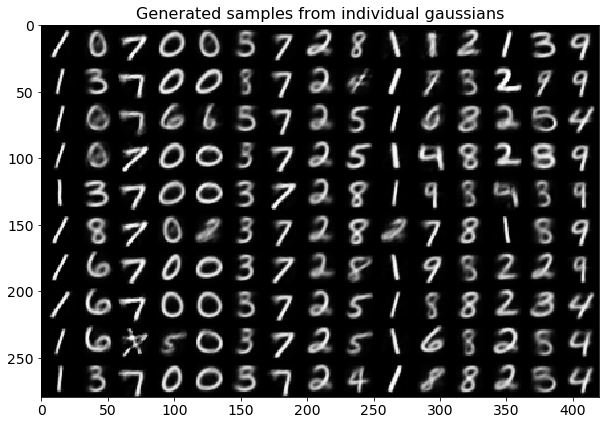

In [34]:
generated_h = list()
for i in range(sigma.shape[0]): #sigma.shape[0]
    generated_h.append( np.random.multivariate_normal(mu[i,:], np.diag(sigma[i,:]), 10) )
    
generated_h = (np.concatenate(generated_h)*h_std) + h_mean

generated_x = sess.run([tf.sigmoid(gen_conf.y)], feed_dict={gen_conf.inputs : generated_h})

generated_img = img_rearange(np.reshape(generated_x[0], [-1,28,28]), 10, sigma.shape[0])


fig = plt.figure(); ax = fig.gca()
plt.rcParams["figure.figsize"] = [10, 10]
ax.imshow(generated_img, cmap='gray')
ax.set_title( 'Generated samples from individual gaussians')

## Plot embedding

#### embedding using Training dataset

(1000, 2)


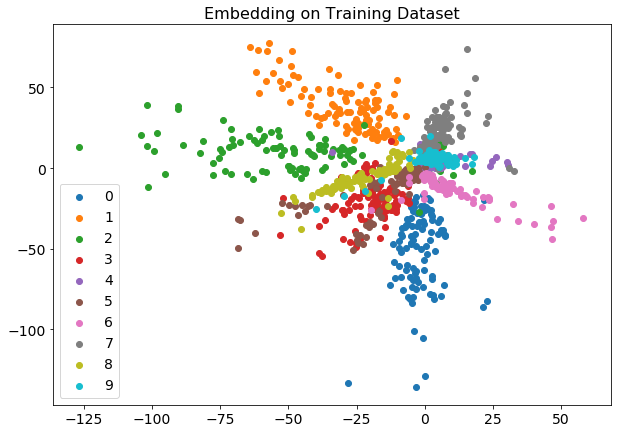

In [29]:
# get batch
batch_x, batch_y= mnist.train.next_batch(1000)
labels = np.argmax(batch_y, 1)
#get embeeding
h_x_data = sess.run([enc_conf.y],feed_dict={enc_conf.inputs : batch_x})
h_x_data = h_x_data[0]

print(h_x_data.shape)

# plot
fig = plt.figure(); ax = fig.gca()
plt.rcParams["figure.figsize"] = [10, 7]
plt.rcParams["axes.titlesize"] =16
plt.rcParams["font.size"] =14
plt.rcParams["legend.fontsize"] =14


if h_x_data.shape[1]==2:
    for i in range(10):
        ax.scatter(h_x_data[labels==i, 0], h_x_data[labels==i, 1], label=str(i))
        
ax.set_title( 'Embedding on Training Dataset')
ax.legend()

#### embedding using Testing dataset

(1000, 2)


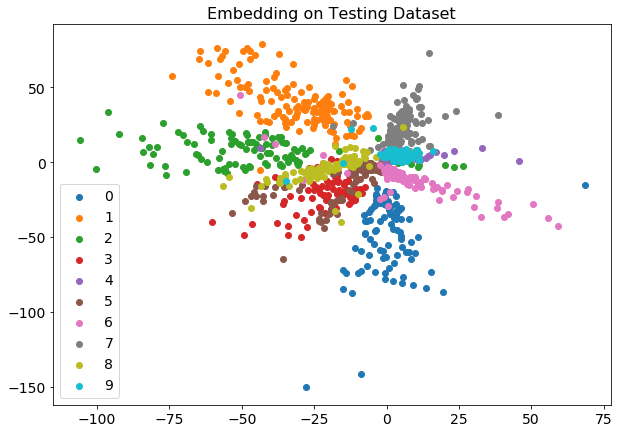

In [32]:
# get batch
batch_x, batch_y= mnist.test.next_batch(1000)
labels = np.argmax(batch_y, 1)
#get embeeding
h_x_data = sess.run([enc_conf.y],feed_dict={enc_conf.inputs : batch_x})
h_x_data = h_x_data[0]

print(h_x_data.shape)

# plot
fig = plt.figure(); ax = fig.gca()
plt.rcParams["figure.figsize"] = [10, 7]
plt.rcParams["axes.titlesize"] =16
plt.rcParams["font.size"] =14
plt.rcParams["legend.fontsize"] =14


if h_x_data.shape[1]==2:
    for i in range(10):
        ax.scatter(h_x_data[labels==i, 0], h_x_data[labels==i, 1], label=str(i))
        
ax.set_title( 'Embedding on Testing Dataset')
ax.legend()

In [26]:
opt

{'auto_learning_rate': 0.01,
 'batch_size': 1000,
 'classifier_weight': 0.0,
 'gmm_learning_rate': 0.001,
 'max_steps': 15000,
 'n_hidden_class': [100, 100],
 'n_hidden_dec': [100, 80, 500],
 'n_hidden_enc': [500, 80, 100],
 'n_kernels': 15,
 'n_outputs_enc': 2,
 'tol': 1e-09,
 'weight_loss': 5e-05}